In [1]:
import os.path as osp
import GPUtil
import torch.nn as nn
import torch
from focal_loss.focal_loss import FocalLoss

from torch.nn import TransformerEncoder, TransformerEncoderLayer
import os
from torch_geometric.data import Dataset, download_url
from torch_geometric.loader import DataLoader
import pandas as pd
from performance import performances_val
from PIL import Image
from torch.nn import Linear
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.data import Data
from sklearn import metrics
import numpy as np
from tqdm import tqdm
from torch_geometric.nn import ChebConv, GraphSAGE,GraphUNet ,TransformerConv

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
seed = 1378
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
landmark_colors = np.load("landmark_colors.npy")
from sklearn.preprocessing import OneHotEncoder
one_hot_list=[]
enc = OneHotEncoder()
enc.fit(np.expand_dims(landmark_colors,axis=1))  
for x in landmark_colors:
    one_hot_list.append(enc.transform([[x]]).toarray()[0])
one_hot_arr  = np.array(one_hot_list)
one_hot_arr = torch.FloatTensor(one_hot_arr)

m = torch.nn.Softmax(dim=-1)

class landmark_dataset(Dataset):
    def __init__(self, info_list, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(None, transform, pre_transform, pre_filter)
        
        self.graphs = pd.read_csv(info_list, delimiter=",", header=None)


    def len(self):
        return len(self.graphs)

    def get(self, idx):
        
        graph_path = self.graphs.iloc[idx]
        graph_path = graph_path[0]
        
        
        data = torch.load(graph_path)
        #data.x =data.x.t()
        return data 
class landmark_dataset_train(Dataset):
    def __init__(self, info_list, transform=None, pre_transform=None, pre_filter=None):
        super().__init__(None, transform, pre_transform, pre_filter)
        
        self.graphs = pd.read_csv(info_list, delimiter=",", header=None)


    def len(self):
        return len(self.graphs)

    def get(self, idx):
        
        graph_path = self.graphs.iloc[idx]
        graph_path = graph_path[0]
        
        data = torch.load(graph_path)
        
 
        
        domain_name = graph_path.split("/")[-4]
        
            
        if domain_name == "MSU_MFSD" :
            
            domain_label = 0
            
        elif domain_name == "Replay_attack_dataset" :
            
            domain_label = 1
            
        elif domain_name == "oulu" :
            
            domain_label = 2
        else :
            print(graph_path,domain_name )
            raise "error"
            
        
        data = Data(x=data.x, edge_index=data.edge_index,y =data.y,data = domain_label,y_node = one_hot_arr)

        #data.x =data.x.t()
        return data 
train_dataset = landmark_dataset_train("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/graph_train_O_M_I.txt")
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True,num_workers=16,pin_memory=True)

test_dataset = landmark_dataset("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/graph_test_C.txt")
test_loader = DataLoader(test_dataset, batch_size=1,num_workers=16)
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# فرض کنید که داده‌های ورودی شما یک توالی از ۶۸۰ ویژگی دارد.
#sequence_length = 128
#feature_dim = 4  # هر ویژگی تک‌بعدی است

# نمونه داده ورودی (تعداد نمونه‌ها × طول توالی × بعد ویژگی)
#inputs = torch.rand(32, sequence_length, feature_dim)  # 32 نمونه با 680 ویژگی تک‌بعدی

# تعریف یک لایه ترنسفورمر انکودر
class SimpleTransformer(nn.Module):
    def __init__(self, embed_dim, num_layers, nhead,n_out):
        super(SimpleTransformer, self).__init__()
        self.linear = nn.Linear(4, embed_dim)  # افزایش بعد ویژگی‌ها
        self.encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(128 * embed_dim, n_out)  # فرضا 10 کلاس خروجی داریم

    def forward(self, x):
        x = self.linear(x)  # تغییر بعد ویژگی‌ها
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # فشرده‌سازی به یک بردار برای طبقه‌بندی
        feuture = x
        x = self.fc(x)
        return x

# # ایجاد مدل و ارسال ورودی
# # model = SimpleTransformer(embed_dim=embed_dim, num_layers=2, nhead=4)
# # output = model(inputs)

# #print(output.shape)
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# فرض کنید که داده‌های ورودی شما یک توالی از ۶۸۰ ویژگی دارد.
sequence_length = 128
feature_dim = 1  # هر ویژگی تک‌بعدی است

# نمونه داده ورودی (تعداد نمونه‌ها × طول توالی × بعد ویژگی)
#inputs = torch.rand(32, sequence_length, feature_dim)  # 32 نمونه با 680 ویژگی تک‌بعدی

# تعریف یک لایه ترنسفورمر انکودر
class SimpleTransformer_2(nn.Module):
    def __init__(self, embed_dim, num_layers, nhead):
        super(SimpleTransformer_2, self).__init__()
        self.linear = nn.Linear(feature_dim, embed_dim)  # افزایش بعد ویژگی‌ها
        self.encoder_layer = TransformerEncoderLayer(d_model=embed_dim, nhead=nhead)
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(sequence_length * embed_dim, 7)  # فرضا 10 کلاس خروجی داریم

    def forward(self, x):
        x = self.linear(x)  # تغییر بعد ویژگی‌ها
        x = self.transformer_encoder(x)
        x = x.view(x.size(0), -1)  # فشرده‌سازی به یک بردار برای طبقه‌بندی
        x = self.fc(x)
        return x

# # ایجاد مدل و ارسال ورودی
# # model = SimpleTransformer(embed_dim=embed_dim, num_layers=2, nhead=4)
# # output = model(inputs)

# #print(output.shape)


In [2]:
class RandomNodeDropout(nn.Module):
    def __init__(self, drop_prob=0.3):
        super(RandomNodeDropout, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x, enabled=True):
        if not self.training or not enabled:
            return x
        
        num_rows = x.size(0)
        mask = torch.rand(num_rows, device=x.device) > self.drop_prob
        mask = mask.float().unsqueeze(1).expand_as(x)
        x = x * mask
        
        return x

soft = torch.nn.Softmax(dim=1)

num_domain = 3
class GRL(nn.Module):

    def __init__(self, max_iter):
        super(GRL, self).__init__()
        self.iter_num = 0
        self.alpha = 10
        self.low = 0.0
        self.high = 1.0
        self.max_iter = max_iter

    def forward(self, input):
        self.iter_num += 1
        return input * 1.0

    def backward(self, gradOutput):
        coeff = np.float(2.0 * (self.high - self.low) / (1.0 + np.exp(-self.alpha * self.iter_num / self.max_iter))
                         - (self.high - self.low) + self.low)
        return -coeff*10* gradOutput

num_node  =train_dataset.num_node_features
class Discriminator(torch.nn.Module):
    def __init__(self,hidden_channels ,max_iter):
        super(Discriminator, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv2 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv3 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv4 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.grl_layer = GRL(max_iter)
        self.fc2 = nn.Linear(hidden_channels, num_domain)
        
    def forward(self, x, edge_index, batch,drop_en):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        
        x = self.grl_layer(x)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.drop_1(x,drop_en)
        
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.drop_2(x,drop_en)
        
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        
        x = global_mean_pool(x, batch)
        
        x = self.fc2(x)
        x = m(x)
         
        return x 



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels,max_iter=4000):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = ChebConv(num_node, hidden_channels,2)
        self.conv2 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv3 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv4 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv5 = ChebConv(hidden_channels*2, hidden_channels,2)
        self.conv6 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv7 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv8 = ChebConv(hidden_channels, hidden_channels,2)
        self.lin = SimpleTransformer(8,5,8,1)
        
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.drop_3 = RandomNodeDropout(drop_prob=0.3)
        self.drop_4 = RandomNodeDropout(drop_prob=0.3)
        self.drop_5 = RandomNodeDropout(drop_prob=0.3)
        self.drop_6 = RandomNodeDropout(drop_prob=0.3)
        
        
        self.b1 = BatchNorm(hidden_channels)
        self.b2 = BatchNorm(hidden_channels)
        self.b3 = BatchNorm(hidden_channels)
        self.b4 = BatchNorm(hidden_channels)
        self.b5 = BatchNorm(hidden_channels)
        self.b6 = BatchNorm(hidden_channels)
        self.b7 = BatchNorm(hidden_channels)
        
        self.dis = Discriminator(hidden_channels,max_iter)
        
        self.conv1_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.conv2_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.lin_node_class = SimpleTransformer_2(64,10,8)
        

        
        #self.tcn = Simple1DCNN()
        
    def forward(self, x, edge_index, batch,drop_en,index_arr):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        

        x = self.conv1(x, edge_index)
        x  = self.b1(x)
        x = x.relu()
        
        x = self.drop_1(x,drop_en)
        
        

        x = self.conv2(x, edge_index)
        x  = self.b2(x)
        x = x.relu()
        
        x = self.drop_2(x,drop_en)
                
        dicriminator = x
        
        x_1 = global_mean_pool(x, batch)
        
        x = self.conv3(x, edge_index)
        x  = self.b3(x)
        x = x.relu()
        
        x = self.drop_3(x,drop_en)
        
        x_3 = global_mean_pool(x, batch)
        
        
        x = self.conv4(x, edge_index)
        x  = self.b4(x)
        x = x.relu()
        
        x = self.drop_4(x,drop_en)
        
        
        x = torch.cat((x,dicriminator),dim=1) #skip connection
        
        x = self.conv5(x, edge_index)
        x  = self.b5(x)
        x = x.relu()
        
        x = self.drop_5(x,drop_en)
        
        x_5 = global_mean_pool(x, batch)
        
        x = self.conv6(x, edge_index)
        x  = self.b6(x)
        x = x.relu()
        
        x = self.drop_6(x,drop_en)
        
        x = self.conv7(x, edge_index)
        x  = self.b7(x)
        x = x.relu()
        
        
        x = self.conv8(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        x = torch.stack([x,x_1,x_5,x_3],dim=2)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        #x = torch.unsqueeze(x,2)
        #print(x.shape)
        
        x,_ = self.lin(x)
        
        x= x.sigmoid()
        
        
        node_class_hidden = self.conv1_node_class(dicriminator,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        node_class_hidden = self.conv2_node_class(node_class_hidden,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        #print(index_arr.shape , node_class_hidden.shape)
        
        node_class_hidden = node_class_hidden[index_arr]
        
        #print(node_class_hidden.shape)
        node_class_hidden = torch.unsqueeze(node_class_hidden, dim=2)
        
        node_pre = self.lin_node_class(node_class_hidden)
        
            
        #print("hiiii :" , dicriminator.shape)
        dis_invariant = self.dis(dicriminator,edge_index,batch,drop_en)
        
        return x ,dis_invariant ,node_pre,dicriminator

model = GCN(hidden_channels=128).to(device)
print(model)

def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#criterion = torch.nn.CrossEntropyLoss()
criterion= nn.BCELoss()
criterion_node_class=  torch.nn.CrossEntropyLoss()
criterion_2 = FocalLoss(gamma=2)
def train(epoch):
    model.train()
    losses_adv_loss=0
    losses_loss_cls=0
    total_loss = 0
    losses_node_cls_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training dataset.
        graph = graph.to(device)  # Move data to the device
        
        drop_en = bool(np.random.binomial(1, 0.5))
        
        if graph.x.shape[0] < 29952 :
            
            if graph.x.shape[0] < 64:
            
                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :
                
                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :
                
            index_arr = torch.randint(0, 29952, (64,)).to(device)
        
        
        
        out,domain_invariant,node_pre,feature = model(graph.x, graph.edge_index, graph.batch,drop_en,index_arr)  # Perform a single forward pass.
        print(graph.data.shape,domain_invariant.shape)
        adv_loss = criterion_2(domain_invariant, graph.data)
        
        node_cls_loss = criterion_node_class(node_pre.squeeze(),graph.y_node.float()[index_arr])
        #print(out.shape , graph.y.long().shape)
        loss_cls = criterion(out.squeeze(), graph.y.float())  # Compute the loss.
        
        loss_all = adv_loss + loss_cls + node_cls_loss
        loss_all.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        total_loss = loss_all + total_loss
        losses_adv_loss = adv_loss + losses_adv_loss
        losses_loss_cls = loss_cls + losses_loss_cls
        losses_node_cls_loss = node_cls_loss + losses_node_cls_loss


    print("/////////////////////////")
    print("adverserial loss : " ,losses_adv_loss/len(train_loader.dataset))  
    print("classification loss : " , losses_loss_cls/len(train_loader.dataset))
    print("classification node loss : " , losses_node_cls_loss/len(train_loader.dataset))
    print("total loss : " ,total_loss/len(train_loader.dataset) )
    print("////////////////////////////////////")
def test(loader,epoch):
    score_path = os.path.join("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores", "epoch_{}".format(epoch+1))
    check_folder(score_path)
    model.eval()
    with torch.no_grad():
        scores_list = []

        correct = 0
        s= 0
        progress_bar = tqdm(loader, desc=f'Epoch {epoch+1}', unit='batch')
        for graph in progress_bar:  # Iterate in batches over the training/test dataset.
            if graph.x.shape[0] < 29952 :

                if graph.x.shape[0] < 64:

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
                else :

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
            else :

                index_arr = torch.randint(0, 29952, (64,)).to(device)
                
            graph = graph.to(device)  # Move data to the device
            logit,_ ,_,_= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
            live_label = graph.y.float()
            for i in range(len(logit)):
                        scores_list.append("{} {}\n".format(logit[i].item(), live_label[i].item()))
  # Check against ground-truth labels.
    map_score_val_filename = os.path.join(score_path, "score.txt")
    with open(map_score_val_filename, 'w') as file:
                file.writelines(scores_list)
    print("score: write test scores to {}".format(map_score_val_filename))
    test_ACC, fpr, FRR, HTER, auc_test, test_err, tpr = performances_val(map_score_val_filename)
    print("epoch:{:d}, test:  val_ACC={:.4f}, HTER={:.4f}, AUC={:.4f}, val_err={:.4f}, ACC={:.4f}, TPR={:.4f}".format(
        epoch + 1, test_ACC, HTER, auc_test, test_err, test_ACC, tpr))  
    return auc_test




GCN(
  (conv1): ChebConv(640, 128, K=2, normalization=sym)
  (conv2): ChebConv(128, 128, K=2, normalization=sym)
  (conv3): ChebConv(128, 128, K=2, normalization=sym)
  (conv4): ChebConv(128, 128, K=2, normalization=sym)
  (conv5): ChebConv(256, 128, K=2, normalization=sym)
  (conv6): ChebConv(128, 128, K=2, normalization=sym)
  (conv7): ChebConv(128, 128, K=2, normalization=sym)
  (conv8): ChebConv(128, 128, K=2, normalization=sym)
  (lin): SimpleTransformer(
    (linear): Linear(in_features=4, out_features=8, bias=True)
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
      )
      (linear1): Linear(in_features=8, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=8, bias=True)
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((8,), ep

In [43]:
train(1)

Epoch 2:   0%|                                    | 0/213872 [00:01<?, ?batch/s]

torch.Size([1]) torch.Size([1, 3])


ValueError: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.

In [35]:
model.load_state_dict(torch.load("Focal_without_pipline_domain_generalization_tuning.pth",map_location='cuda'))


<All keys matched successfully>

In [36]:
loader = train_loader

In [37]:
model.eval()
y_list = []
feature_list = []
domains = []
with torch.no_grad():
    scores_list = []

    correct = 0
    s= 0
    progress_bar = tqdm(loader, desc=f'Epoch {0+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training/test dataset.
        if graph.x.shape[0] < 29952 :

            if graph.x.shape[0] < 64:

                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :

                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :

            index_arr = torch.randint(0, 29952, (64,)).to(device)

        graph = graph.to(device)  # Move data to the device
        logit,_ ,_,features= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
        live_label = graph.y.float()
        y_list.append(live_label.cpu().numpy())
        feature_list.append(features.cpu().numpy())
        domains.append(graph.data.cpu().numpy())


Epoch 1:   0%|                         | 43/213872 [00:01<2:42:14, 21.97batch/s]


KeyboardInterrupt: 

In [1]:
features.shape

NameError: name 'features' is not defined

In [38]:
loader = test_loader
model.eval()
y_list_target = []
feature_list_target = []
with torch.no_grad():
    scores_list = []

    correct = 0
    s= 0
    progress_bar = tqdm(loader, desc=f'Epoch {0+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training/test dataset.
        if graph.x.shape[0] < 29952 :

            if graph.x.shape[0] < 64:

                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :

                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :

            index_arr = torch.randint(0, 29952, (64,)).to(device)

        graph = graph.to(device)  # Move data to the device
        
        logit,a ,_,features= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
        print(a.shape,graph.data.shape)
        live_label = graph.y.float()
        y_list_target.append(live_label.cpu().numpy())
        feature_list_target.append(features.cpu().numpy())


Epoch 1:   0%|                                     | 0/22296 [00:00<?, ?batch/s]


AttributeError: 'GlobalStorage' object has no attribute 'data'

In [7]:
features.shape

torch.Size([468, 128])

In [17]:
11232/468

24.0

In [22]:
y_list_target= np.concatenate(y_list_target)
feature_list_target= np.array(feature_list_target)


In [23]:
y_list= np.concatenate(y_list)

In [24]:
feature_list = np.array(feature_list)
domains = np.concatenate(domains)


In [11]:
feature_list.shape

(5363, 468, 128)

In [25]:

a = feature_list

b = feature_list_target

In [28]:
feature_list = a[:,400,:]
feature_list_target = b[:,400,:]

/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_8645/3098538043.py:35: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring t

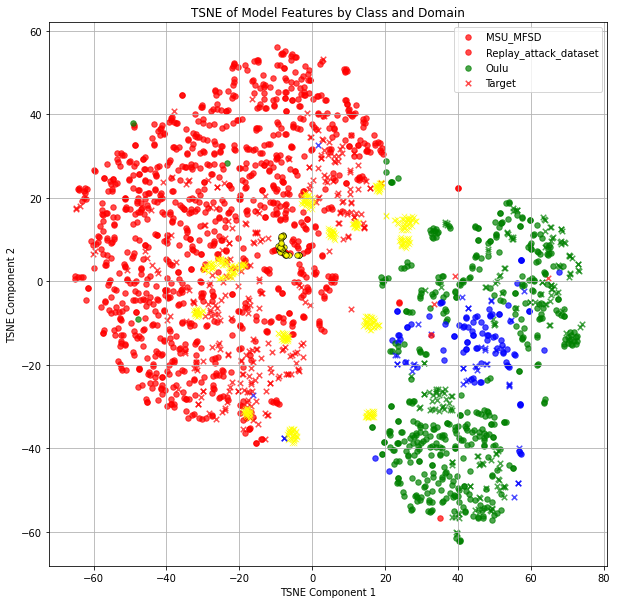

In [29]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# داده‌های ورودی (مثال فرضی)
# فرض کنید feature_list داده‌های ویژگی‌ها است
# و y_list لیبل‌ها، domain_list دامنه‌ها را نشان می‌دهد
# target_feature و target_label داده‌های هدف هستند

# اجرای TSNE برای کاهش ابعاد به 2
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(feature_list)

# رنگ‌های مختلف برای دامنه‌ها
colors = {0: 'blue', 1: 'green', 2: 'red'}

# رسم نمودار TSNE
plt.figure(figsize=(10, 10))

# رسم نقاط براساس دامنه‌ها و لیبل‌ها
for i, (x, y, domain, label) in enumerate(zip(X_tsne, y_list, domains, y_list)):
    if label == 0:
        marker = 'o'  # دایره برای کلاس 0
    else:
        marker = 'x'  # ضربدر برای کلاس 1
    plt.scatter(x[0], x[1], color=colors[domain], marker=marker, s=30, alpha=0.7)

# افزودن داده‌های هدف به نمودار
target_tsne = tsne.fit_transform(feature_list_target)
for x, label in zip(target_tsne, y_list_target):
    if label == 0:
        marker = 'o'  # دایره برای کلاس 0
    else:
        marker = 'x'  # ضربدر برای کلاس 1
    plt.scatter(x[0], x[1], color='yellow', marker=marker, s=30, edgecolor='black', linewidth=0.6, alpha=0.9)

# تنظیمات نمودار
plt.title("TSNE of Model Features by Class and Domain")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend(['MSU_MFSD', 'Replay_attack_dataset', 'Oulu', 'Target'], loc='upper right')
plt.grid(True)
plt.show()


/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


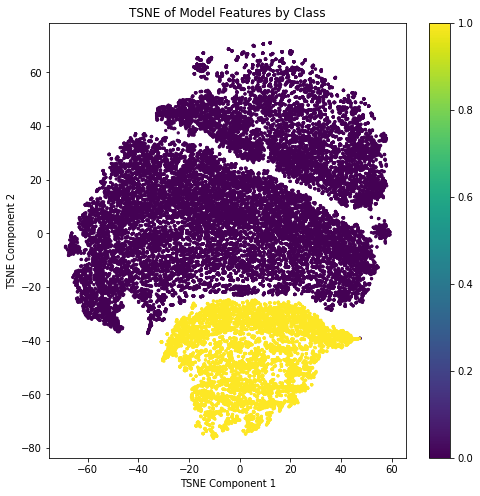

In [27]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# فرض کنید X داده‌های ویژگی و y لیبل‌های کلاس‌ها باشد
# X: خروجی مدل شما که شامل بردارهای ویژگی است
# y: برچسب‌های کلاس‌های شما

# اجرای TSNE برای کاهش ابعاد به 2
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(feature_list)

# رسم نمودار TSNE
plt.figure(figsize=(8, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_list, cmap='viridis', s=5)
plt.colorbar(scatter)
plt.title("TSNE of Model Features by Class")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.show()


In [41]:
loader = test_loader

In [42]:
model.eval()
y_list = []
feature_list = []
with torch.no_grad():
    scores_list = []

    correct = 0
    s= 0
    progress_bar = tqdm(loader, desc=f'Epoch {0+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training/test dataset.
        if graph.x.shape[0] < 29952 :

            if graph.x.shape[0] < 64:

                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :

                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :

            index_arr = torch.randint(0, 29952, (64,)).to(device)

        graph = graph.to(device)  # Move data to the device
        logit,_ ,_,features= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
        live_label = graph.y.float()
        y_list.append(live_label.cpu().numpy())
        feature_list.append(features.cpu().numpy())


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 349/349 [00:48<00:00,  7.24batch/s]


In [43]:
y_list= np.concatenate(y_list)

In [44]:
feature_list = np.concatenate(feature_list)

/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


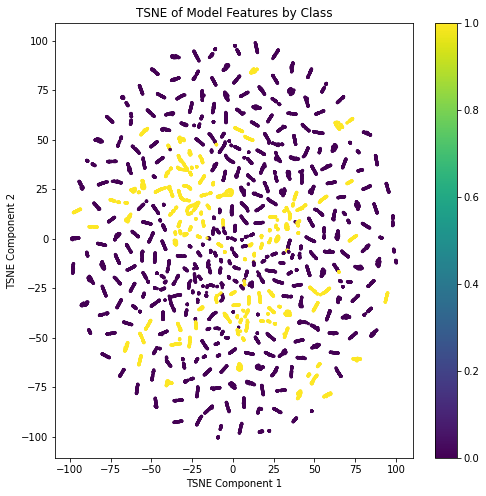

In [45]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# فرض کنید X داده‌های ویژگی و y لیبل‌های کلاس‌ها باشد
# X: خروجی مدل شما که شامل بردارهای ویژگی است
# y: برچسب‌های کلاس‌های شما

# اجرای TSNE برای کاهش ابعاد به 2
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(feature_list)

# رسم نمودار TSNE
plt.figure(figsize=(8, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_list, cmap='viridis', s=5)
plt.colorbar(scatter)
plt.title("TSNE of Model Features by Class")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.show()


In [40]:
test(loader,0)

Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 349/349 [00:54<00:00,  6.45batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_1/score.txt
epoch:1, test:  val_ACC=0.9537, HTER=0.0464, AUC=0.9855, val_err=0.0464, ACC=0.9537, TPR=0.9545


0.9854837664701319

In [3]:
from __future__ import print_function

import torch
import torch.nn as nn


class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        # modified to handle edge cases when there is no positive pair
        # for an anchor point. 
        # Edge case e.g.:- 
        # features of shape: [4,1,...]
        # labels:            [0,1,1,2]
        # loss before mean:  [nan, ..., ..., nan] 
        mask_pos_pairs = mask.sum(1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask_pos_pairs

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [4]:
class RandomNodeDropout(nn.Module):
    def __init__(self, drop_prob=0.3):
        super(RandomNodeDropout, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x, enabled=True):
        if not self.training or not enabled:
            return x
        
        num_rows = x.size(0)
        mask = torch.rand(num_rows, device=x.device) > self.drop_prob
        mask = mask.float().unsqueeze(1).expand_as(x)
        x = x * mask
        
        return x

soft = torch.nn.Softmax(dim=1)

num_domain = 3
class GRL(nn.Module):

    def __init__(self, max_iter):
        super(GRL, self).__init__()
        self.iter_num = 0
        self.alpha = 10
        self.low = 0.0
        self.high = 1.0
        self.max_iter = max_iter

    def forward(self, input):
        self.iter_num += 1
        return input * 1.0

    def backward(self, gradOutput):
        coeff = np.float(2.0 * (self.high - self.low) / (1.0 + np.exp(-self.alpha * self.iter_num / self.max_iter))
                         - (self.high - self.low) + self.low)
        return -coeff*10* gradOutput

num_node  =train_dataset.num_node_features
class Discriminator(torch.nn.Module):
    def __init__(self,hidden_channels ,max_iter):
        super(Discriminator, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv2 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv3 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv4 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.grl_layer = GRL(max_iter)
        self.fc2 = nn.Linear(hidden_channels, num_domain)
        
    def forward(self, x, edge_index, batch,drop_en):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        
        x = self.grl_layer(x)
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.drop_1(x,drop_en)
        
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.drop_2(x,drop_en)
        
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        
        x = global_mean_pool(x, batch)
        
        x = self.fc2(x)
        x = m(x)
         
        return x 



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels,max_iter=4000):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = ChebConv(num_node, hidden_channels,2)
        self.conv2 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv3 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv4 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv5 = ChebConv(hidden_channels*2, hidden_channels,2)
        self.conv6 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv7 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv8 = ChebConv(hidden_channels, hidden_channels,2)
        self.lin = SimpleTransformer(8,5,8,1)
        
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.drop_3 = RandomNodeDropout(drop_prob=0.3)
        self.drop_4 = RandomNodeDropout(drop_prob=0.3)
        self.drop_5 = RandomNodeDropout(drop_prob=0.3)
        self.drop_6 = RandomNodeDropout(drop_prob=0.3)
        
        
        self.b1 = BatchNorm(hidden_channels)
        self.b2 = BatchNorm(hidden_channels)
        self.b3 = BatchNorm(hidden_channels)
        self.b4 = BatchNorm(hidden_channels)
        self.b5 = BatchNorm(hidden_channels)
        self.b6 = BatchNorm(hidden_channels)
        self.b7 = BatchNorm(hidden_channels)
        
        self.dis = Discriminator(hidden_channels,max_iter)
        
        self.conv1_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.conv2_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.lin_node_class = SimpleTransformer_2(64,10,8)
        

        
        #self.tcn = Simple1DCNN()
        
    def forward(self, x, edge_index, batch,drop_en,index_arr):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        

        x = self.conv1(x, edge_index)
        x  = self.b1(x)
        x = x.relu()
        
        x = self.drop_1(x,drop_en)
        
        

        x = self.conv2(x, edge_index)
        x  = self.b2(x)
        x = x.relu()
        
        x = self.drop_2(x,drop_en)
                
        dicriminator = x
        
        x_1 = global_mean_pool(x, batch)
        
        x = self.conv3(x, edge_index)
        x  = self.b3(x)
        x = x.relu()
        
        x = self.drop_3(x,drop_en)
        
        x_3 = global_mean_pool(x, batch)
        
        
        x = self.conv4(x, edge_index)
        x  = self.b4(x)
        x = x.relu()
        
        x = self.drop_4(x,drop_en)
        
        
        x = torch.cat((x,dicriminator),dim=1) #skip connection
        
        x = self.conv5(x, edge_index)
        x  = self.b5(x)
        x = x.relu()
        
        x = self.drop_5(x,drop_en)
        
        x_5 = global_mean_pool(x, batch)
        
        x = self.conv6(x, edge_index)
        x  = self.b6(x)
        x = x.relu()
        
        x = self.drop_6(x,drop_en)
        
        x = self.conv7(x, edge_index)
        x  = self.b7(x)
        x = x.relu()
        
        
        x = self.conv8(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        x = torch.stack([x,x_1,x_5,x_3],dim=2)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        #x = torch.unsqueeze(x,2)
        #print(x.shape)
        
        x,feature = self.lin(x)
        
        x= x.sigmoid()
        
        
        node_class_hidden = self.conv1_node_class(dicriminator,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        node_class_hidden = self.conv2_node_class(node_class_hidden,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        #print(index_arr.shape , node_class_hidden.shape)
        
        node_class_hidden = node_class_hidden[index_arr]
        
        #print(node_class_hidden.shape)
        node_class_hidden = torch.unsqueeze(node_class_hidden, dim=2)
        
        node_pre = self.lin_node_class(node_class_hidden)
        
            
        #print("hiiii :" , dicriminator.shape)
        dis_invariant = self.dis(dicriminator,edge_index,batch,drop_en)
        
        return x ,dis_invariant ,node_pre,feature

model = GCN(hidden_channels=128).to(device)
print(model)

def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#criterion = torch.nn.CrossEntropyLoss()
criterion= nn.BCELoss()
criterion_node_class=  torch.nn.CrossEntropyLoss()
criterion_2 = FocalLoss(gamma=2)
Contrast_loss = SupConLoss(temperature=0.1)

def train(epoch):
    model.train()
    losses_adv_loss=0
    losses_loss_cls=0
    total_loss = 0
    losses_node_cls_loss = 0
    losses_con =0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training dataset.
        graph = graph.to(device)  # Move data to the device
        
        drop_en = bool(np.random.binomial(1, 0.5))
        
        if graph.x.shape[0] < 29952 :
            
            if graph.x.shape[0] < 64:
            
                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :
                
                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :
                
            index_arr = torch.randint(0, 29952, (64,)).to(device)
        
        
        
        out,domain_invariant,node_pre,feature = model(graph.x, graph.edge_index, graph.batch,drop_en,index_arr)  # Perform a single forward pass.
        
        adv_loss = criterion_2(domain_invariant, graph.data)
        
        normilized_features= F.normalize(feature, p=2, dim=1)
        
        normilized_features = normilized_features.unsqueeze(dim=1)
        
        #print(normilized_features.shape)

        con_loss = Contrast_loss(normilized_features, graph.y.float())
        
        node_cls_loss = criterion_node_class(node_pre.squeeze(),graph.y_node.float()[index_arr])
        #print(out.shape , graph.y.long().shape)
        loss_cls = criterion(out.squeeze(), graph.y.float())  # Compute the loss.
        
        loss_all = adv_loss + loss_cls + node_cls_loss + con_loss
        loss_all.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        total_loss = loss_all + total_loss
        losses_adv_loss = adv_loss + losses_adv_loss
        losses_loss_cls = loss_cls + losses_loss_cls
        losses_node_cls_loss = node_cls_loss + losses_node_cls_loss
        losses_con = con_loss + losses_con


    print("/////////////////////////")
    print("adverserial loss : " ,losses_adv_loss/len(train_loader.dataset))  
    print("classification loss : " , losses_loss_cls/len(train_loader.dataset))
    print("classification node loss : " , losses_node_cls_loss/len(train_loader.dataset))
    print("Contrastive loss : " ,losses_con/len(train_loader.dataset) )
    print("total loss : " ,total_loss/len(train_loader.dataset) )
    print("////////////////////////////////////")
def test(loader,epoch):
    score_path = os.path.join("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores", "epoch_{}".format(epoch+1))
    check_folder(score_path)
    model.eval()
    with torch.no_grad():
        scores_list = []

        correct = 0
        s= 0
        progress_bar = tqdm(loader, desc=f'Epoch {epoch+1}', unit='batch')
        for graph in progress_bar:  # Iterate in batches over the training/test dataset.
            if graph.x.shape[0] < 29952 :

                if graph.x.shape[0] < 64:

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
                else :

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
            else :

                index_arr = torch.randint(0, 29952, (64,)).to(device)
                
            graph = graph.to(device)  # Move data to the device
            logit,_ ,_,_= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
            live_label = graph.y.float()
            for i in range(len(logit)):
                        scores_list.append("{} {}\n".format(logit[i].item(), live_label[i].item()))
  # Check against ground-truth labels.
    map_score_val_filename = os.path.join(score_path, "score.txt")
    with open(map_score_val_filename, 'w') as file:
                file.writelines(scores_list)
    print("score: write test scores to {}".format(map_score_val_filename))
    test_ACC, fpr, FRR, HTER, auc_test, test_err, tpr = performances_val(map_score_val_filename)
    print("epoch:{:d}, test:  val_ACC={:.4f}, HTER={:.4f}, AUC={:.4f}, val_err={:.4f}, ACC={:.4f}, TPR={:.4f}".format(
        epoch + 1, test_ACC, HTER, auc_test, test_err, test_ACC, tpr))  
    return auc_test




GCN(
  (conv1): ChebConv(640, 128, K=2, normalization=sym)
  (conv2): ChebConv(128, 128, K=2, normalization=sym)
  (conv3): ChebConv(128, 128, K=2, normalization=sym)
  (conv4): ChebConv(128, 128, K=2, normalization=sym)
  (conv5): ChebConv(256, 128, K=2, normalization=sym)
  (conv6): ChebConv(128, 128, K=2, normalization=sym)
  (conv7): ChebConv(128, 128, K=2, normalization=sym)
  (conv8): ChebConv(128, 128, K=2, normalization=sym)
  (lin): SimpleTransformer(
    (linear): Linear(in_features=4, out_features=8, bias=True)
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
      )
      (linear1): Linear(in_features=8, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=8, bias=True)
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((8,), ep

In [5]:
model.load_state_dict(torch.load("Focal_without_pipline_domain_generalization_tuning.pth",map_location='cuda'))
best_auc = 0.9855
for epoch in range(0, 1000):
    train(epoch)
    print("***************************")
    #print("train : ")
    #train_auc = test(train_loader,epoch)
    print("test : ")
    test_auc = test(test_loader,epoch)
    if test_auc > best_auc:
        print("improve acc .. .. ..")
        torch.save(model.state_dict(), 'Focal_without_pipline_domain_generalization_tuning.pth')
        best_auc = test_auc
        continue 

Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████| 3342/3342 [08:17<00:00,  6.71batch/s]


/////////////////////////
adverserial loss :  tensor(4.5333e-12, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(6.3215e-06, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.6217e-05, device='cuda:0', grad_fn=<DivBackward0>)
Contrastive loss :  tensor(0.0815, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0816, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 349/349 [00:52<00:00,  6.60batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_1/score.txt
epoch:1, test:  val_ACC=0.9479, HTER=0.2193, AUC=0.8198, val_err=0.2229, ACC=0.9479, TPR=0.0000


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████| 3342/3342 [08:16<00:00,  6.73batch/s]


/////////////////////////
adverserial loss :  tensor(9.9635e-07, device='cuda:0', grad_fn=<DivBackward0>)
classification loss :  tensor(1.2595e-05, device='cuda:0', grad_fn=<DivBackward0>)
classification node loss :  tensor(2.7430e-05, device='cuda:0', grad_fn=<DivBackward0>)
Contrastive loss :  tensor(0.0811, device='cuda:0', grad_fn=<DivBackward0>)
total loss :  tensor(0.0812, device='cuda:0', grad_fn=<DivBackward0>)
////////////////////////////////////
***************************
test : 


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 349/349 [00:50<00:00,  6.86batch/s]


score: write test scores to /home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores/epoch_2/score.txt
epoch:2, test:  val_ACC=0.8393, HTER=0.1607, AUC=0.8959, val_err=0.1607, ACC=0.8393, TPR=0.7320


Epoch 3:   0%|▏                                                                                          | 8/3342 [00:05<37:41,  1.47batch/s]


KeyboardInterrupt: 

In [69]:
class RandomNodeDropout(nn.Module):
    def __init__(self, drop_prob=0.3):
        super(RandomNodeDropout, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x, enabled=True):
        if not self.training or not enabled:
            return x
        
        num_rows = x.size(0)
        mask = torch.rand(num_rows, device=x.device) > self.drop_prob
        mask = mask.float().unsqueeze(1).expand_as(x)
        x = x * mask
        
        return x

soft = torch.nn.Softmax(dim=1)

num_domain = 3
class GRL(nn.Module):

    def __init__(self, max_iter):
        super(GRL, self).__init__()
        self.iter_num = 0
        self.alpha = 10
        self.low = 0.0
        self.high = 1.0
        self.max_iter = max_iter

    def forward(self, input):
        self.iter_num += 1
        return input * 1.0

    def backward(self, gradOutput):
        coeff = np.float(2.0 * (self.high - self.low) / (1.0 + np.exp(-self.alpha * self.iter_num / self.max_iter))
                         - (self.high - self.low) + self.low)
        return -coeff*10* gradOutput

num_node  =train_dataset.num_node_features
class Discriminator_2(torch.nn.Module):
    def __init__(self,hidden_channels ,max_iter):
        super(Discriminator_2, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv2 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv3 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv4 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.grl_layer = GRL(max_iter)
        self.fc2 = nn.Linear(hidden_channels, num_domain)
        
    def forward(self, x, edge_index, batch,drop_en):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        
        x = self.grl_layer(x)
        x = self.conv1(x, edge_index)
        x = x.relu()        
        x = self.conv2(x, edge_index)
        x = x.relu()
                
        x = self.fc2(x)
        x = m(x)
         
        return x 

class Discriminator(torch.nn.Module):
    def __init__(self,hidden_channels ,max_iter):
        super(Discriminator, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv2 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv3 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.conv4 = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.grl_layer = GRL(max_iter)
        self.fc2 = nn.Linear(hidden_channels, num_domain)
        
    def forward(self, x, edge_index, batch,drop_en):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        
        x = self.grl_layer(x)
        x = self.conv1(x, edge_index)
        x = x.relu()        
        x = self.conv2(x, edge_index)
        x = x.relu()
                
        x = self.fc2(x)
        x = m(x)
         
        return x 

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels,max_iter=4000):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = ChebConv(num_node, hidden_channels,2)
        self.conv2 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv3 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv4 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv5 = ChebConv(hidden_channels*2, hidden_channels,2)
        self.conv6 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv7 = ChebConv(hidden_channels, hidden_channels,2)
        self.conv8 = ChebConv(hidden_channels, hidden_channels,2)
        self.lin = SimpleTransformer(8,5,8,1)
        
        self.drop_1 = RandomNodeDropout(drop_prob=0.3)
        self.drop_2 = RandomNodeDropout(drop_prob=0.3)
        self.drop_3 = RandomNodeDropout(drop_prob=0.3)
        self.drop_4 = RandomNodeDropout(drop_prob=0.3)
        self.drop_5 = RandomNodeDropout(drop_prob=0.3)
        self.drop_6 = RandomNodeDropout(drop_prob=0.3)
        
        
        self.b1 = BatchNorm(hidden_channels)
        self.b2 = BatchNorm(hidden_channels)
        self.b3 = BatchNorm(hidden_channels)
        self.b4 = BatchNorm(hidden_channels)
        self.b5 = BatchNorm(hidden_channels)
        self.b6 = BatchNorm(hidden_channels)
        self.b7 = BatchNorm(hidden_channels)
        
        self.dis = Discriminator(hidden_channels,max_iter)
        
        self.conv1_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.conv2_node_class = GraphSAGE(hidden_channels, hidden_channels,2,dropout=0.5)
        
        self.lin_node_class = SimpleTransformer_2(64,10,8)
        

        
        #self.tcn = Simple1DCNN()
        
    def forward(self, x, edge_index, batch,drop_en,index_arr):
        #print("graph fea :",graph_level_feature.shape ,edge_index.shape )
        

        x = self.conv1(x, edge_index)
        x  = self.b1(x)
        x = x.relu()
        
        x = self.drop_1(x,drop_en)
        
        

        x = self.conv2(x, edge_index)
        x  = self.b2(x)
        x = x.relu()
        
        x = self.drop_2(x,drop_en)
                
        dicriminator = x
        
        x_1 = global_mean_pool(x, batch)
        
        x = self.conv3(x, edge_index)
        x  = self.b3(x)
        x = x.relu()
        
        x = self.drop_3(x,drop_en)
        
        x_3 = global_mean_pool(x, batch)
        
        
        x = self.conv4(x, edge_index)
        x  = self.b4(x)
        x = x.relu()
        
        x = self.drop_4(x,drop_en)
        
        
        x = torch.cat((x,dicriminator),dim=1) #skip connection
        
        x = self.conv5(x, edge_index)
        x  = self.b5(x)
        x = x.relu()
        
        x = self.drop_5(x,drop_en)
        
        x_5 = global_mean_pool(x, batch)
        
        x = self.conv6(x, edge_index)
        x  = self.b6(x)
        x = x.relu()
        
        x = self.drop_6(x,drop_en)
        
        x = self.conv7(x, edge_index)
        x  = self.b7(x)
        x = x.relu()
        
        
        x = self.conv8(x, edge_index)
        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        
        x = torch.stack([x,x_1,x_5,x_3],dim=2)
        
        x = F.dropout(x, p=0.5, training=self.training)
        
        #x = torch.unsqueeze(x,2)
        #print(x.shape)
        
        x = self.lin(x)
        
        x= x.sigmoid()
        
        
        node_class_hidden = self.conv1_node_class(dicriminator,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        node_class_hidden = self.conv2_node_class(node_class_hidden,edge_index)
        node_class_hidden = node_class_hidden.relu()
        
        #print(index_arr.shape , node_class_hidden.shape)
        
        node_class_hidden = node_class_hidden[index_arr]
        
        #print(node_class_hidden.shape)
        node_class_hidden = torch.unsqueeze(node_class_hidden, dim=2)
        
        node_pre = self.lin_node_class(node_class_hidden)
        
            
        #print("hiiii :" , dicriminator.shape)
        dis_invariant = self.dis(dicriminator,edge_index,batch,drop_en)
        
        return x ,dis_invariant ,node_pre ,dicriminator

model = GCN(hidden_channels=128).to(device)
print(model)

def check_folder(log_dir):
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    return log_dir

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
#criterion = torch.nn.CrossEntropyLoss()
criterion= nn.BCELoss()
criterion_node_class=  torch.nn.CrossEntropyLoss()
criterion_2 = FocalLoss(gamma=2)
def train(epoch):
    model.train()
    losses_adv_loss=0
    losses_loss_cls=0
    total_loss = 0
    losses_node_cls_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training dataset.
        graph = graph.to(device)  # Move data to the device
        
        drop_en = bool(np.random.binomial(1, 0.5))
        
        if graph.x.shape[0] < 29952 :
            
            if graph.x.shape[0] < 64:
            
                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :
                
                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :
                
            index_arr = torch.randint(0, 29952, (64,)).to(device)
        
        
        
        out,domain_invariant,node_pre = model(graph.x, graph.edge_index, graph.batch,drop_en,index_arr)  # Perform a single forward pass.
        
        
        adv_loss = criterion_2(domain_invariant, graph.data.long())
        
        node_cls_loss = criterion_node_class(node_pre.squeeze(),graph.y_node.float()[index_arr])
        #print(out.shape , graph.y.long().shape)
        loss_cls = criterion(out.squeeze(), graph.y.float())  # Compute the loss.
        
        loss_all = adv_loss + loss_cls + node_cls_loss
        loss_all.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        total_loss = loss_all + total_loss
        losses_adv_loss = adv_loss + losses_adv_loss
        losses_loss_cls = loss_cls + losses_loss_cls
        losses_node_cls_loss = node_cls_loss + losses_node_cls_loss


    print("/////////////////////////")
    print("adverserial loss : " ,losses_adv_loss/len(train_loader.dataset))  
    print("classification loss : " , losses_loss_cls/len(train_loader.dataset))
    print("classification node loss : " , losses_node_cls_loss/len(train_loader.dataset))
    print("total loss : " ,total_loss/len(train_loader.dataset) )
    print("////////////////////////////////////")
def test(loader,epoch):
    score_path = os.path.join("/home/hassan-hossein/single_image_graph_face_anti_spoofing/train/Scores", "epoch_{}".format(epoch+1))
    check_folder(score_path)
    model.eval()
    with torch.no_grad():
        scores_list = []

        correct = 0
        s= 0
        progress_bar = tqdm(loader, desc=f'Epoch {epoch+1}', unit='batch')
        for graph in progress_bar:  # Iterate in batches over the training/test dataset.
            if graph.x.shape[0] < 29952 :

                if graph.x.shape[0] < 64:

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
                else :

                    index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
            else :

                index_arr = torch.randint(0, 29952, (64,)).to(device)
                
            graph = graph.to(device)  # Move data to the device
            logit,_ ,_= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
            live_label = graph.y.float()
            for i in range(len(logit)):
                        scores_list.append("{} {}\n".format(logit[i].item(), live_label[i].item()))
  # Check against ground-truth labels.
    map_score_val_filename = os.path.join(score_path, "score.txt")
    with open(map_score_val_filename, 'w') as file:
                file.writelines(scores_list)
    print("score: write test scores to {}".format(map_score_val_filename))
    test_ACC, fpr, FRR, HTER, auc_test, test_err, tpr = performances_val(map_score_val_filename)
    print("epoch:{:d}, test:  val_ACC={:.4f}, HTER={:.4f}, AUC={:.4f}, val_err={:.4f}, ACC={:.4f}, TPR={:.4f}".format(
        epoch + 1, test_ACC, HTER, auc_test, test_err, test_ACC, tpr))  
    return auc_test




GCN(
  (conv1): ChebConv(640, 128, K=2, normalization=sym)
  (conv2): ChebConv(128, 128, K=2, normalization=sym)
  (conv3): ChebConv(128, 128, K=2, normalization=sym)
  (conv4): ChebConv(128, 128, K=2, normalization=sym)
  (conv5): ChebConv(256, 128, K=2, normalization=sym)
  (conv6): ChebConv(128, 128, K=2, normalization=sym)
  (conv7): ChebConv(128, 128, K=2, normalization=sym)
  (conv8): ChebConv(128, 128, K=2, normalization=sym)
  (lin): SimpleTransformer(
    (linear): Linear(in_features=4, out_features=8, bias=True)
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
      )
      (linear1): Linear(in_features=8, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=8, bias=True)
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((8,), ep

In [70]:
model.load_state_dict(torch.load("Focal_without_pipline_domain_generalization_tuning_mohemm_to_c.pth",map_location='cuda'))


<All keys matched successfully>

In [71]:
loader = train_loader

In [72]:
model.eval()
y_list = []
feature_list = []
domains = []
with torch.no_grad():
    scores_list = []

    correct = 0
    s= 0
    progress_bar = tqdm(loader, desc=f'Epoch {0+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training/test dataset.
        if graph.x.shape[0] < 29952 :

            if graph.x.shape[0] < 64:

                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :

                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :

            index_arr = torch.randint(0, 29952, (64,)).to(device)

        graph = graph.to(device)  # Move data to the device
        logit,_ ,_,features= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
        live_label = graph.y.float()
        y_list.append(live_label.cpu().numpy())
        feature_list.append(features.cpu().numpy())
        domains.append(graph.data.cpu().numpy())


Epoch 1:   0%|                       | 1011/213872 [01:06<3:53:02, 15.22batch/s]


KeyboardInterrupt: 

In [74]:
loader = test_loader
model.eval()
y_list_target = []
feature_list_target = []
with torch.no_grad():
    scores_list = []

    correct = 0
    s= 0
    progress_bar = tqdm(loader, desc=f'Epoch {0+1}', unit='batch')
    for graph in progress_bar:  # Iterate in batches over the training/test dataset.
        if graph.x.shape[0] < 29952 :

            if graph.x.shape[0] < 64:

                index_arr = torch.randint(0, int(graph.x.shape[0]), (int(graph.x.shape[0]),)).to(device)
            else :

                index_arr = torch.randint(0, int(graph.x.shape[0]), (64,)).to(device)
        else :

            index_arr = torch.randint(0, 29952, (64,)).to(device)

        graph = graph.to(device)  # Move data to the device
        
        logit,a ,_,features= model(graph.x, graph.edge_index, graph.batch,False,index_arr)
        live_label = graph.y.float()
        y_list_target.append(live_label.cpu().numpy())
        feature_list_target.append(features.cpu().numpy())


Epoch 1:   2%|▋                          | 539/22296 [00:40<27:34, 13.15batch/s]


KeyboardInterrupt: 

In [75]:
y_list_target= np.concatenate(y_list_target)
feature_list_target= np.array(feature_list_target)


In [76]:
y_list= np.concatenate(y_list)

In [77]:
feature_list = np.array(feature_list)
domains = np.concatenate(domains)


In [78]:
a = feature_list

b = feature_list_target

In [79]:
feature_list = a[:,400,:]
feature_list_target = b[:,400,:]

/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hassan-hossein/anaconda3/envs/Wav2Lip/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/tmp/ipykernel_8645/3098538043.py:35: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring t

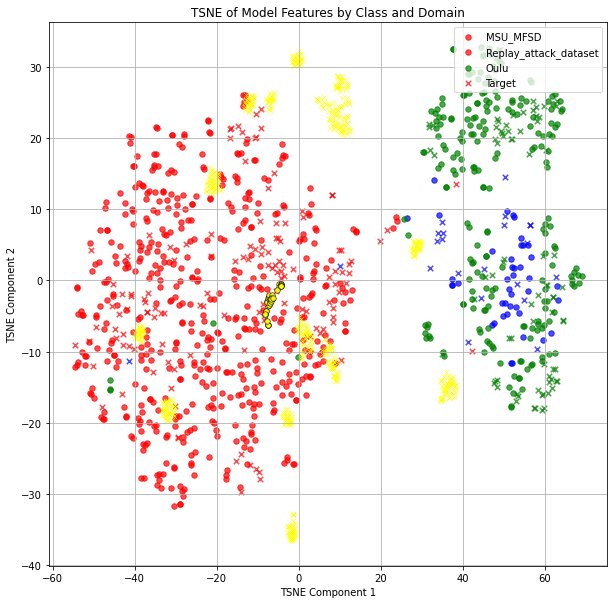

In [80]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# داده‌های ورودی (مثال فرضی)
# فرض کنید feature_list داده‌های ویژگی‌ها است
# و y_list لیبل‌ها، domain_list دامنه‌ها را نشان می‌دهد
# target_feature و target_label داده‌های هدف هستند

# اجرای TSNE برای کاهش ابعاد به 2
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(feature_list)

# رنگ‌های مختلف برای دامنه‌ها
colors = {0: 'blue', 1: 'green', 2: 'red'}

# رسم نمودار TSNE
plt.figure(figsize=(10, 10))

# رسم نقاط براساس دامنه‌ها و لیبل‌ها
for i, (x, y, domain, label) in enumerate(zip(X_tsne, y_list, domains, y_list)):
    if label == 0:
        marker = 'o'  # دایره برای کلاس 0
    else:
        marker = 'x'  # ضربدر برای کلاس 1
    plt.scatter(x[0], x[1], color=colors[domain], marker=marker, s=30, alpha=0.7)

# افزودن داده‌های هدف به نمودار
target_tsne = tsne.fit_transform(feature_list_target)
for x, label in zip(target_tsne, y_list_target):
    if label == 0:
        marker = 'o'  # دایره برای کلاس 0
    else:
        marker = 'x'  # ضربدر برای کلاس 1
    plt.scatter(x[0], x[1], color='yellow', marker=marker, s=30, edgecolor='black', linewidth=0.6, alpha=0.9)

# تنظیمات نمودار
plt.title("TSNE of Model Features by Class and Domain")
plt.xlabel("TSNE Component 1")
plt.ylabel("TSNE Component 2")
plt.legend(['MSU_MFSD', 'Replay_attack_dataset', 'Oulu', 'Target'], loc='upper right')
plt.grid(True)
plt.show()
